In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, norm

USER SETTINGS

In [32]:
excel_path = r"Z:\UriMons\cFos\Results\ROIs_correlations\Groups_cfos_scores.xlsx"   # <-- change this to your file
method = "pearson"      # "pearson" or "spearman"
alpha = 0.05            # significance level AFTER MCC
mcc_method = "fdr_bh"   # "fdr_bh", "bonferroni", or "none"

sheet_names = ["WT_control", "WT_EPA", "KO_control", "KO_EPA"]
roi_header_candidates = ["ROI/Mouse", "ROI", "Region", "ROIs"]

HELPERS

In [33]:
def find_roi_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return df.columns[0]

def compute_roi_corr(df, roi_col, method="pearson"):
    """
    Input df: first column = ROI names; remaining columns = mice (numeric).
    Returns: (corr_df, n_mice)
    """
    numeric = df.drop(columns=[roi_col], errors="ignore").apply(pd.to_numeric, errors="coerce")
    numeric.index = df[roi_col].astype(str).str.strip()
    corr = numeric.T.corr(method=method)  # pairwise complete observations
    n_mice = numeric.shape[1]
    return corr, n_mice

def fisher_z(r):
    r = np.clip(r, -0.999999, 0.999999)
    return 0.5 * np.log((1 + r) / (1 - r))

def correlation_significance(r, n):
    """
    Two-tailed p-values for H0: r=0 with df=n-2 (Pearson).
    If method='spearman', this is an approximation.
    """
    dfree = n - 2
    with np.errstate(divide='ignore', invalid='ignore'):
        t_vals = r * np.sqrt(np.maximum(dfree, 0) / np.maximum(1 - r**2, np.finfo(float).eps))
    p_vals = 2 * (1 - t.cdf(np.abs(t_vals), max(dfree, 1)))
    return p_vals

def safe_sym_max_abs(arr, fallback=1.0):
    arr = np.asarray(arr)
    masked = arr[np.abs(arr) < 0.999]
    v = np.nanmax(np.abs(masked)) if masked.size else fallback
    return float(v if np.isfinite(v) and v > 0 else fallback)

def get_gray_nan_cmap(base_cmap="bwr", nan_color="grey"):
    cmap_obj = plt.get_cmap(base_cmap).copy()
    cmap_obj.set_bad(color=nan_color)
    return cmap_obj

def p_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

def _bh_fdr(pvals_1d):
    """
    Benjamini–Hochberg FDR control: returns adjusted p-values in original order.
    """
    p = np.asarray(pvals_1d, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    q = ranked * n / (np.arange(1, n + 1))
    q = np.minimum.accumulate(q[::-1])[::-1]  # monotone
    q = np.clip(q, 0, 1)
    p_adj = np.empty_like(q)
    p_adj[order] = q
    return p_adj

def _apply_mcc_to_matrix(p_df: pd.DataFrame, method: str, alpha: float):
    """
    Apply MCC to symmetric p-value matrix (diagonal ignored).
    Returns:
      p_adj_df  - adjusted p-values (diag NaN)
      sig_mask  - boolean mask where adjusted p < alpha (diag False).
    """
    p = p_df.copy()
    n = p.shape[0]
    iu, ju = np.triu_indices(n, k=1)
    p_vec = p.values[iu, ju]
    valid = np.isfinite(p_vec)

    if method == "none":
        p_adj_vec = p_vec.copy()
    elif method == "bonferroni":
        m = int(valid.sum())
        factor = m if m > 0 else 1
        p_adj_vec = np.clip(p_vec * factor, 0, 1)
    elif method == "fdr_bh":
        p_adj_vec = p_vec.copy()
        if valid.any():
            p_adj_vec[valid] = _bh_fdr(p_vec[valid])
    else:
        raise ValueError(f"Unknown mcc_method: {method}")

    p_adj = np.full_like(p.values, np.nan, dtype=float)
    p_adj[iu, ju] = p_adj_vec
    p_adj[ju, iu] = p_adj_vec
    p_adj_df = pd.DataFrame(p_adj, index=p_df.index, columns=p_df.columns)

    sig = (p_adj_df < alpha)
    sig = sig.fillna(False)
    np.fill_diagonal(sig.values, False)
    return p_adj_df, sig

def plot_corr_heatmap_r(r_df, sig_mask_df, title, out_path,
                        cmap="bwr", vmin=-1, vmax=1,
                        cbar_label="Pearson r", p_adj_df=None):
    """
    Heatmap for Pearson r with gray NaNs and stars only where sig_mask_df is True.
    If p_adj_df is provided, stars reflect tiers by adjusted p-values.
    """
    fig, ax = plt.subplots(figsize=(8, 7))
    cmap_obj = get_gray_nan_cmap(cmap, nan_color="grey")
    im = ax.imshow(r_df, cmap=cmap_obj, vmin=vmin, vmax=vmax)

    ax.set_title(title, fontsize=12)
    ax.set_xticks(range(len(r_df.columns))); ax.set_yticks(range(len(r_df.index)))
    ax.set_xticklabels(r_df.columns, rotation=90, fontsize=7)
    ax.set_yticklabels(r_df.index, fontsize=7)
    ax.set_xticks(np.arange(-.5, len(r_df.columns), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(r_df.index), 1), minor=True)
    ax.grid(which="minor", color="k", linestyle="-", linewidth=0.2)

    for i in range(len(r_df.index)):
        for j in range(len(r_df.columns)):
            if bool(sig_mask_df.iloc[i, j]):
                star = '*' if p_adj_df is None or np.isnan(p_adj_df.iloc[i, j]) else p_to_stars(float(p_adj_df.iloc[i, j]))
                if star:
                    ax.text(j, i, star, ha='center', va='center',
                            color='black', fontsize=10, fontweight='bold')

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(cbar_label, rotation=270, labelpad=12)
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close(fig)

def fisher_z_diff_test(z1_df: pd.DataFrame, z2_df: pd.DataFrame, n1: int, n2: int):
    """
    Fisher r-to-z difference test for independent correlations.
    Returns z_stat (DataFrame) and p (DataFrame).
    """
    z1, z2 = z1_df.align(z2_df, join="inner")
    if n1 <= 3 or n2 <= 3:
        # degenerate SE; return NaNs
        z_stat = z1 * np.nan
        p = z1 * np.nan
        return z_stat, p
    se = np.sqrt(1.0 / (n1 - 3) + 1.0 / (n2 - 3))
    z_stat = (z1 - z2) / se
    p = 2.0 * (1.0 - norm.cdf(np.abs(z_stat)))
    p = pd.DataFrame(p, index=z_stat.index, columns=z_stat.columns)
    return z_stat, p

def _format_sig_lines_r(df_r: pd.DataFrame,
                        df_z: pd.DataFrame,
                        p_raw_df: pd.DataFrame,
                        p_adj_df: pd.DataFrame,
                        sig_df: pd.DataFrame):
    """
    Build per-group significant correlation summary for the TEXT PANEL and Excel.
    Text shows: partner = r=..., z=..., p_adj=..., p_raw=...
    Returns:
      lines: list[str] for the text panel
      long_table: DataFrame [ROI, Partner, r, z, p_raw, p_adj], sorted by ROI then |r| desc
    """
    rows, lines = [], []
    rois = list(df_r.index)

    for roi in rois:
        partners = []
        for partner in df_r.columns:
            if partner == roi:
                continue
            if bool(sig_df.loc[roi, partner]):
                r      = float(df_r.loc[roi, partner])
                z      = float(df_z.loc[roi, partner])
                p_raw  = float(p_raw_df.loc[roi, partner])
                p_adj  = float(p_adj_df.loc[roi, partner])
                partners.append((partner, r, z, p_raw, p_adj))
        # sort by |r| for readability
        partners.sort(key=lambda x: abs(x[1]), reverse=True)

        # rows for Excel
        for partner, r, z, p_raw, p_adj in partners:
            rows.append({
                "ROI": roi, "Partner": partner, "r": r, "z": z,
                "p_raw": p_raw, "p_adj": p_adj
            })

        if partners:
            parts = [
                f"{prt} = r={r:.3f}, z={z:.3f}, p_adj={p_adj:.2e}, p_raw={p_raw:.2e}"
                for prt, r, z, p_raw, p_adj in partners
            ]
            line = f"{roi}: " + ", ".join(parts)
        else:
            line = f"{roi}: (no significant partners)"
        lines.append(line)

    long_table = pd.DataFrame(rows, columns=["ROI", "Partner", "r", "z", "p_raw", "p_adj"])
    if not long_table.empty:
        long_table["abs_r"] = long_table["r"].abs()
        long_table = long_table.sort_values(["ROI", "abs_r"], ascending=[True, False]).drop(columns=["abs_r"])
    return lines, long_table



def _format_delta_sig_lines(r_A_df: pd.DataFrame,
                            r_B_df: pd.DataFrame,
                            p_adj_df: pd.DataFrame,
                            sig_df: pd.DataFrame,
                            p_raw_df: pd.DataFrame | None = None):
    """
    For Δ lists: uses r from group A and B (e.g., Control and EPA), significance from p_adj_df.
    Text shows: partner = rA - rB = bold(Δ), p_adj=..., [p_raw=...]
    Returns:
      lines: list[str] for the text panel
      long_table: [ROI, Partner, r_A, r_B, delta_r, p_adj, (p_raw if provided)] sorted by |Δ|
    """
    rows, lines = [], []
    rois = list(r_A_df.index)

    for roi in rois:
        parts = []
        for partner in r_A_df.columns:
            if partner == roi:
                continue
            if bool(sig_df.loc[roi, partner]):
                r_a = float(r_A_df.loc[roi, partner])
                r_b = float(r_B_df.loc[roi, partner])
                d   = r_a - r_b
                p_a = float(p_adj_df.loc[roi, partner])
                p_r = float(p_raw_df.loc[roi, partner]) if p_raw_df is not None else None
                parts.append((partner, r_a, r_b, d, p_a, p_r))
        parts.sort(key=lambda x: abs(x[3]), reverse=True)

        for partner, r_a, r_b, d, p_a, p_r in parts:
            row = {"ROI": roi, "Partner": partner, "r_A": r_a, "r_B": r_b, "delta_r": d, "p_adj": p_a}
            if p_r is not None:
                row["p_raw"] = p_r
            rows.append(row)

        if parts:
            chunk = []
            for prt, r_a, r_b, d, p_a, p_r in parts:
                if p_r is None:
                    chunk.append(f"{prt} = {r_a:.3f} - {r_b:.3f} = $\\mathbf{{{d:.3f}}}$, p_adj={p_a:.2e}")
                else:
                    chunk.append(f"{prt} = {r_a:.3f} - {r_b:.3f} = $\\mathbf{{{d:.3f}}}$, p_adj={p_a:.2e}, p_raw={p_r:.2e}")
            line = f"$\\mathbf{{{roi}}}$: " + ", ".join(chunk)
        else:
            line = f"$\\mathbf{{{roi}}}$: (no significant partners)"
        lines.append(line)

    cols = ["ROI", "Partner", "r_A", "r_B", "delta_r", "p_adj"] + (["p_raw"] if p_raw_df is not None else [])
    long_table = pd.DataFrame(rows, columns=cols)
    if not long_table.empty:
        long_table["abs_delta"] = long_table["delta_r"].abs()
        long_table = long_table.sort_values(["ROI", "abs_delta"], ascending=[True, False]).drop(columns=["abs_delta"])
    return lines, long_table


def _save_text_panel(lines, title, out_png, max_chars=110, show=False):
    import textwrap
    wrapped = []
    for ln in lines:
        wrapped.extend(textwrap.wrap(ln, width=max_chars, subsequent_indent="    "))
    n_lines = max(1, len(wrapped))
    fig_h = min(0.35 * n_lines + 1.5, 40)  # cap height
    fig, ax = plt.subplots(figsize=(16, fig_h))
    ax.axis("off")
    ax.text(0.01, 0.99, title, fontsize=14, weight="bold", va="top", family="monospace")
    ax.text(0.01, 0.96, "\n".join(wrapped), fontsize=10, va="top", family="monospace")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)


MAIN PIPELINE

Saved: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_WT_control_pearson_r_heatmap_fdr_bh.png
Saved: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_WT_EPA_pearson_r_heatmap_fdr_bh.png
Saved: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_KO_control_pearson_r_heatmap_fdr_bh.png
Saved: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_KO_EPA_pearson_r_heatmap_fdr_bh.png
Saved Excel workbook with r, z, raw/adj p, and corrected sig masks: Z:\UriMons\cFos\Results\ROIs_correlations\correlations_MCC.xlsx


C:\Users\urimons.WISMAIN\AppData\Local\Temp\ipykernel_16784\2186167197.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


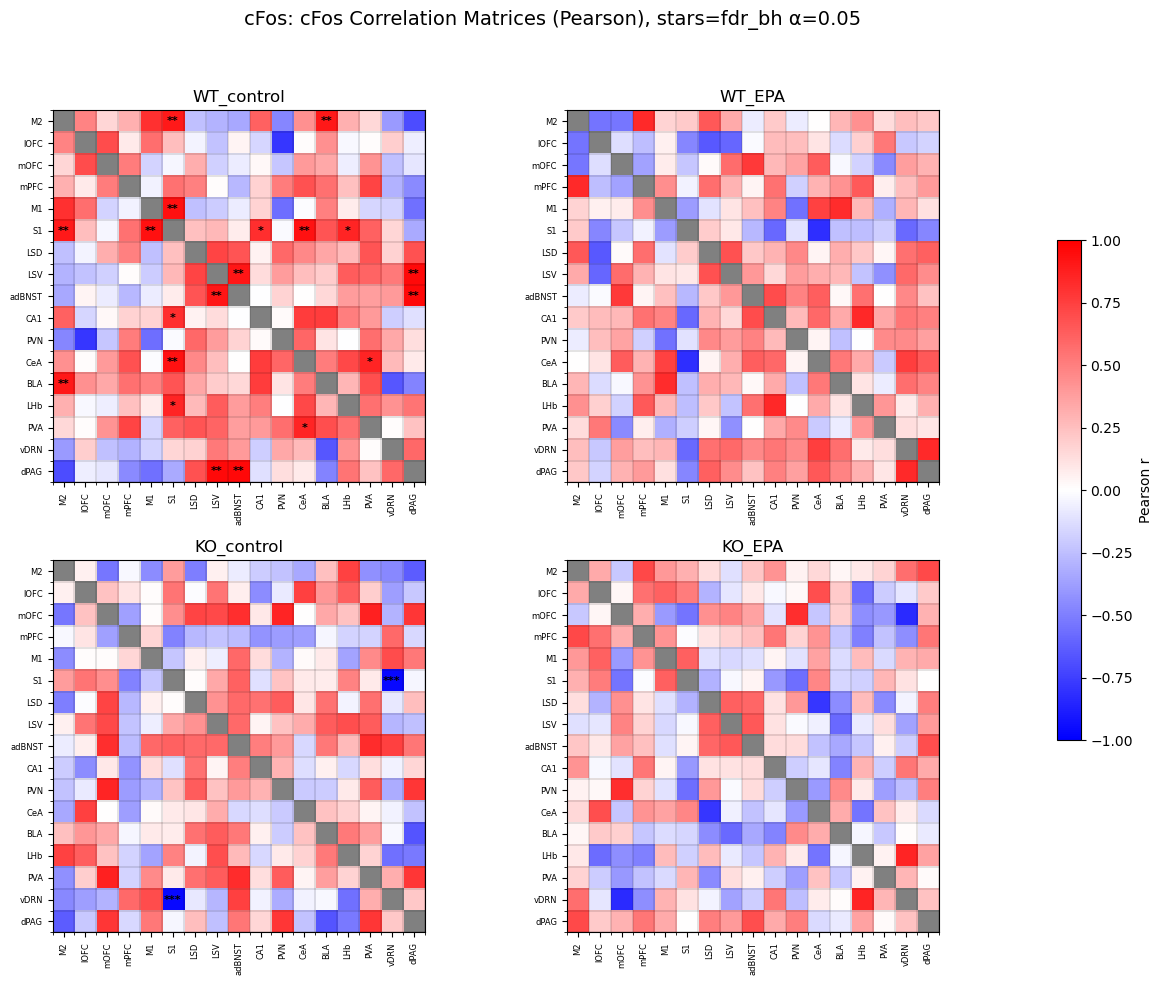

Saved combined r figure: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_combined_r_corr_fdr_bh.png
Saved: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_WT_control_significant_correlations_fdr_bh.png
Saved: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_WT_EPA_significant_correlations_fdr_bh.png
Saved: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_KO_control_significant_correlations_fdr_bh.png
Saved: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_KO_EPA_significant_correlations_fdr_bh.png


In [34]:
wb = pd.ExcelFile(excel_path)
out_dir = os.path.dirname(excel_path)
base = "cFos"  # leave blank to exclude 'Groups_cfos_scores' from file names
out_excel = os.path.join(out_dir, "correlations_MCC.xlsx")

corr_sheets, z_sheets, p_raw_sheets, p_adj_sheets, sig_masks, n_by_sheet = {}, {}, {}, {}, {}, {}

# ---- Per-sheet computations, saving, and plotting (Pearson r with MCC stars) ----
with pd.ExcelWriter(out_excel, engine="openpyxl") as writer:
    for sheet in sheet_names:
        if sheet not in wb.sheet_names:
            print(f"Warning: sheet '{sheet}' not found; skipping.")
            continue

        df = wb.parse(sheet)
        roi_col = find_roi_col(df, roi_header_candidates)
        r_df, n_mice = compute_roi_corr(df, roi_col, method=method)

        # z for later Δ tests; set diagonals to NaN for display symmetry
        z = fisher_z(r_df.values)
        p_raw = correlation_significance(r_df.values, n_mice)

        # zero out diagonals
        np.fill_diagonal(r_df.values, np.nan)
        np.fill_diagonal(z, np.nan)
        np.fill_diagonal(p_raw, np.nan)

        z_df = pd.DataFrame(z, index=r_df.index, columns=r_df.columns)
        p_raw_df = pd.DataFrame(p_raw, index=r_df.index, columns=r_df.columns)

        # MCC
        p_adj_df, sig_df = _apply_mcc_to_matrix(p_raw_df, mcc_method, alpha)

        # store
        corr_sheets[sheet] = r_df
        z_sheets[sheet] = z_df
        p_raw_sheets[sheet] = p_raw_df
        p_adj_sheets[sheet] = p_adj_df
        sig_masks[sheet] = sig_df
        n_by_sheet[sheet] = n_mice

        # Save to Excel
        r_df.to_excel(writer, sheet_name=f"{sheet}_r")
        z_df.to_excel(writer, sheet_name=f"{sheet}_z")
        p_raw_df.to_excel(writer, sheet_name=f"{sheet}_p_raw")
        p_adj_df.to_excel(writer, sheet_name=f"{sheet}_p_{mcc_method}")
        sig_df.astype(int).to_excel(writer, sheet_name=f"{sheet}_sigMask_{mcc_method}")

        # Plot r heatmap with corrected stars
        out_png = os.path.join(out_dir, f"{base}_{sheet}_{method}_r_heatmap_{mcc_method}.png")
        plot_corr_heatmap_r(
            r_df, sig_df,
            f"{sheet} (Pearson r; {mcc_method}, α={alpha})",
            out_png, cbar_label="Pearson r", p_adj_df=p_adj_df
        )
        print(f"Saved: {out_png}")

print(f"Saved Excel workbook with r, z, raw/adj p, and corrected sig masks: {out_excel}")

# ---- Combined 4-panel plot (Pearson r with corrected stars) ----
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
im = None

for i, sheet in enumerate(sheet_names):
    if sheet not in corr_sheets:
        axes[i].axis("off")
        continue
    r_df = corr_sheets[sheet]
    p_adj_df = p_adj_sheets[sheet]
    sig_df = sig_masks[sheet]

    cmap_obj = get_gray_nan_cmap("bwr", nan_color="grey")
    im = axes[i].imshow(r_df, cmap=cmap_obj, vmin=-1, vmax=1)
    axes[i].set_title(sheet, fontsize=12)
    axes[i].set_xticks(range(len(r_df.columns))); axes[i].set_yticks(range(len(r_df.index)))
    axes[i].set_xticklabels(r_df.columns, rotation=90, fontsize=6)
    axes[i].set_yticklabels(r_df.index, fontsize=6)
    axes[i].set_xticks(np.arange(-.5, len(r_df.columns), 1), minor=True)
    axes[i].set_yticks(np.arange(-.5, len(r_df.index), 1), minor=True)
    axes[i].grid(which="minor", color="k", linestyle="-", linewidth=0.15)

    for r_i in range(len(r_df.index)):
        for c_i in range(len(r_df.columns)):
            if sig_df.iloc[r_i, c_i]:
                axes[i].text(c_i, r_i, p_to_stars(float(p_adj_df.iloc[r_i, c_i])),
                             ha='center', va='center', color='black',
                             fontsize=8, fontweight='bold')

cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
if im is not None:
    fig.colorbar(im, cax=cbar_ax, label="Pearson r")
plt.suptitle(f"{base}: cFos Correlation Matrices ({method.title()}), stars={mcc_method} α={alpha}", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

combined_png = os.path.join(out_dir, f"{base}_combined_r_corr_{mcc_method}.png")
plt.savefig(combined_png, dpi=300)
plt.show()
print(f"Saved combined r figure: {combined_png}")

# ---- Significant correlation lists (per group), corrected ----
with pd.ExcelWriter(out_excel, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    for sheet in sheet_names:
        if sheet not in corr_sheets:
            continue
        r_df     = corr_sheets[sheet]
        z_df     = z_sheets[sheet]          # NEW: pass z
        p_raw_df = p_raw_sheets[sheet]      # NEW: pass raw p
        p_adj_df = p_adj_sheets[sheet]      # NEW: pass adjusted p
        sig_df   = sig_masks[sheet]

        lines, long_table = _format_sig_lines_r(r_df, z_df, p_raw_df, p_adj_df, sig_df)

        list_sheet = f"{sheet}_sig_list_{mcc_method}"
        if long_table.empty:
            pd.DataFrame({"info": [f"No significant correlations at {mcc_method} α={alpha}"]}).to_excel(
                writer, sheet_name=list_sheet, index=False
            )
        else:
            long_table.to_excel(writer, sheet_name=list_sheet, index=False)

        out_png = os.path.join(out_dir, f"{base}_{sheet}_significant_correlations_{mcc_method}.png")
        _save_text_panel(
            lines,
            f"{sheet}: Significant ROI correlations ({mcc_method}, α={alpha}, |r| sort)",
            out_png,
            show=False
        )
        print(f"Saved: {out_png}")


Δ  TESTS 

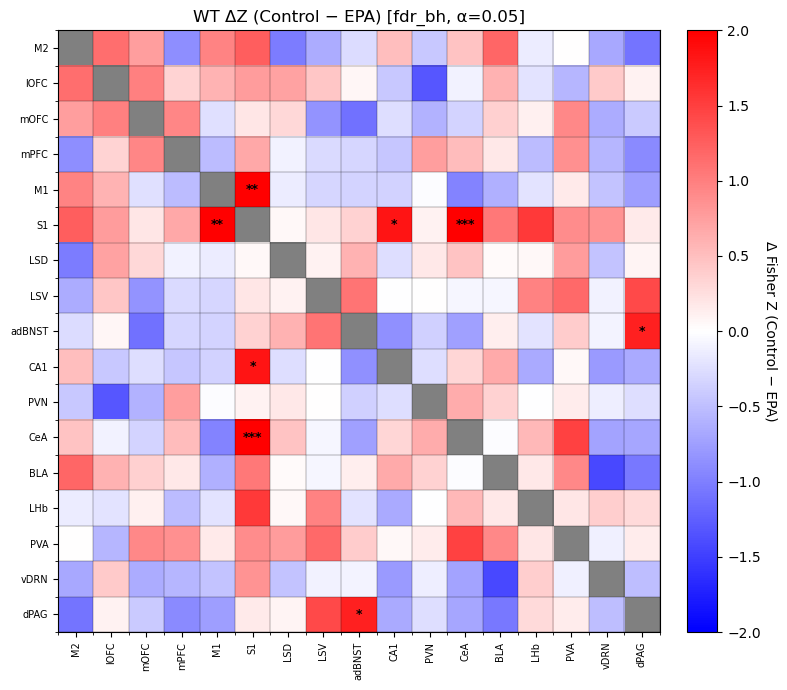

Saved WT ΔZ (with corrected significance) heatmap: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_WT_Diff_Control_minus_EPA_sig_fdr_bh.png
Saved Δ list: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_WT_Delta_significant_correlations_fdr_bh.png


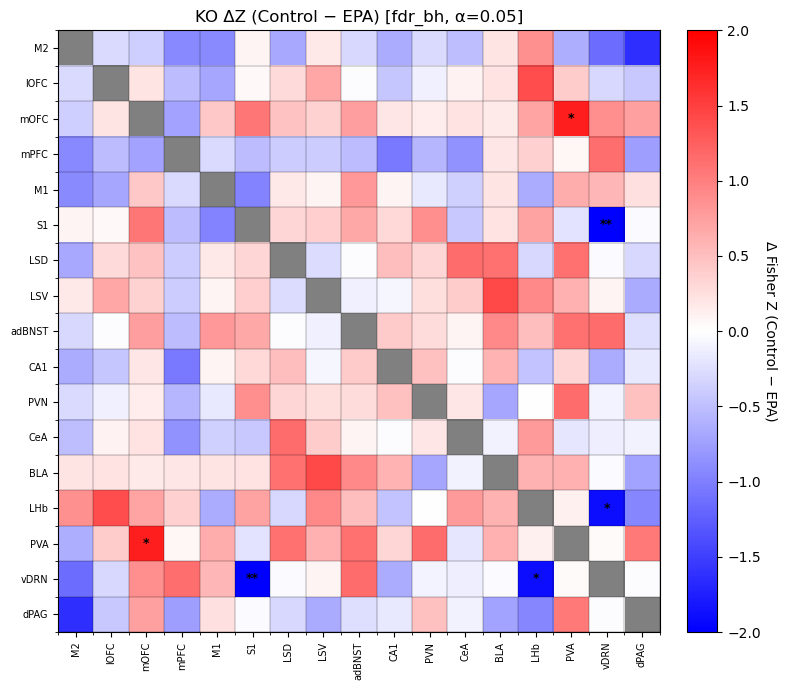

Saved KO ΔZ (with corrected significance) heatmap: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_KO_Diff_Control_minus_EPA_sig_fdr_bh.png
Saved Δ list: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_KO_Delta_significant_correlations_fdr_bh.png


c:\Users\urimons.WISMAIN\AppData\Local\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
c:\Users\urimons.WISMAIN\AppData\Local\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


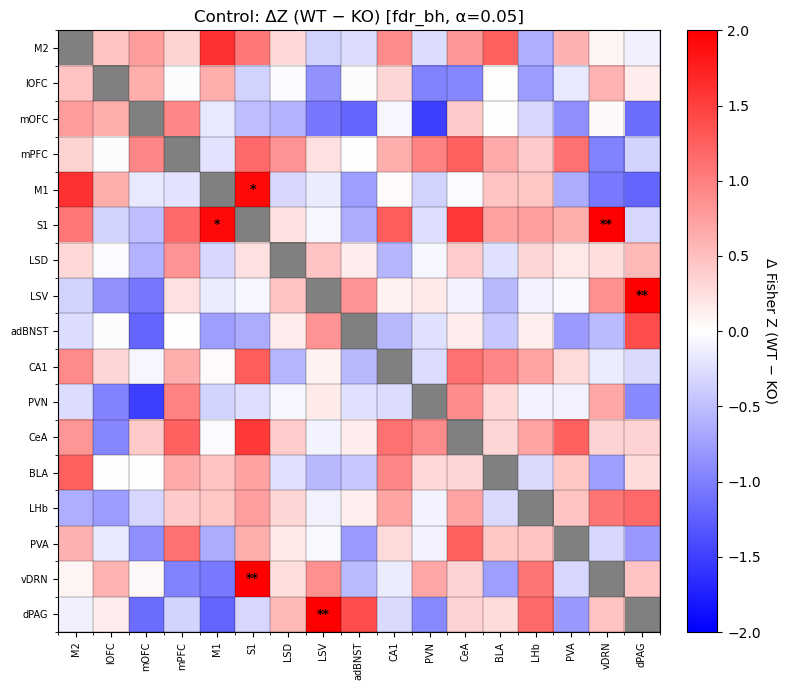

Saved Control ΔZ (WT − KO) heatmap: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_Control_BetweenGenotype_DiffZ_WTminusKO_sig_fdr_bh.png


c:\Users\urimons.WISMAIN\AppData\Local\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Saved Control Δ list: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_Control_BetweenGenotype_Delta_significant_correlations_fdr_bh.png


c:\Users\urimons.WISMAIN\AppData\Local\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


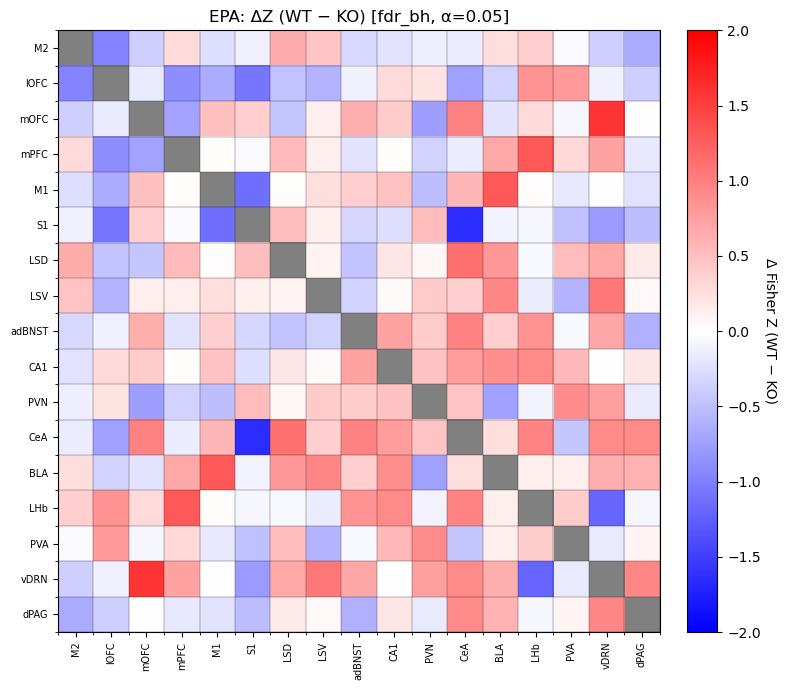

Saved EPA ΔZ (WT − KO) heatmap: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_EPA_BetweenGenotype_DiffZ_WTminusKO_sig_fdr_bh.png


c:\Users\urimons.WISMAIN\AppData\Local\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Saved EPA Δ list: Z:\UriMons\cFos\Results\ROIs_correlations\cFos_EPA_BetweenGenotype_Delta_significant_correlations_fdr_bh.png
All done.


In [35]:
def run_delta_sig_and_plot(geno_label, ctrl_key, epa_key):
    # sanity
    if not all(k in z_sheets for k in [ctrl_key, epa_key]):
        print(f"Skipping {geno_label}: missing {ctrl_key} or {epa_key}")
        return

    z1 = z_sheets[ctrl_key]
    z2 = z_sheets[epa_key]
    n1 = int(n_by_sheet.get(ctrl_key, z1.shape[1] + 3))
    n2 = int(n_by_sheet.get(epa_key, z2.shape[1] + 3))

    # ΔZ
    diff = z1 - z2
    np.fill_diagonal(diff.values, np.nan)

    # difference test
    zstat, pmat_raw = fisher_z_diff_test(z1, z2, n1, n2)

    # MCC
    p_adj_df, sig_df = _apply_mcc_to_matrix(pmat_raw, mcc_method, alpha)
    np.fill_diagonal(sig_df.values, False)

    # Save to Excel
    with pd.ExcelWriter(out_excel, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
        diff.to_excel(writer, sheet_name=f"{geno_label}_Diff_Z_Control_minus_EPA")
        pmat_raw.to_excel(writer, sheet_name=f"{geno_label}_Diff_p_raw")
        p_adj_df.to_excel(writer, sheet_name=f"{geno_label}_Diff_p_{mcc_method}")
        sig_df.astype(int).to_excel(writer, sheet_name=f"{geno_label}_Diff_sigMask_{mcc_method}")

    # Plot ΔZ with corrected stars
    fig, ax = plt.subplots(figsize=(8, 7))
    cmap_obj = get_gray_nan_cmap("bwr", nan_color="grey")
    im = ax.imshow(diff, cmap=cmap_obj, vmin=-2, vmax=2)
    ax.set_title(f"{geno_label} ΔZ (Control − EPA) [{mcc_method}, α={alpha}]", fontsize=12)
    ax.set_xticks(range(len(diff.columns))); ax.set_yticks(range(len(diff.index)))
    ax.set_xticklabels(diff.columns, rotation=90, fontsize=7)
    ax.set_yticklabels(diff.index, fontsize=7)
    ax.set_xticks(np.arange(-.5, len(diff.columns), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(diff.index), 1), minor=True)
    ax.grid(which="minor", color="k", linestyle="-", linewidth=0.2)

    for r_i in range(diff.shape[0]):
        for c_i in range(diff.shape[1]):
            if sig_df.iat[r_i, c_i]:
                star = p_to_stars(float(p_adj_df.iat[r_i, c_i]))
                if star:
                    ax.text(c_i, r_i, star, ha='center', va='center',
                            fontsize=9, fontweight='bold', color='black')

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Δ Fisher Z (Control − EPA)", rotation=270, labelpad=12)
    plt.tight_layout()
    out_png = os.path.join(out_dir, f"{base}_{geno_label}_Diff_Control_minus_EPA_sig_{mcc_method}.png")
    plt.savefig(out_png, dpi=300)
    plt.show()
    print(f"Saved {geno_label} ΔZ (with corrected significance) heatmap: {out_png}")

    # Δ LIST (use r matrices and corrected significance)
    r_ctrl = corr_sheets[ctrl_key]
    r_epa  = corr_sheets[epa_key]

    sig_for_list = sig_df.copy()
    np.fill_diagonal(sig_for_list.values, False)

    delta_lines, delta_table = _format_delta_sig_lines(r_ctrl, r_epa, p_adj_df, sig_for_list, p_raw_df=pmat_raw)

    with pd.ExcelWriter(out_excel, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
        sheetname = f"{geno_label}_Delta_sig_list_{mcc_method}"
        if delta_table.empty:
            pd.DataFrame({"info": [f"No significant Δ (Control − EPA) at {mcc_method} α={alpha}"]}).to_excel(
                writer, sheet_name=sheetname, index=False
            )
        else:
            delta_table.to_excel(writer, sheet_name=sheetname, index=False)

    panel_path = os.path.join(out_dir, f"{base}_{geno_label}_Delta_significant_correlations_{mcc_method}.png")
    _save_text_panel(
        delta_lines,
        f"{geno_label}: Significant Δ correlations (Control − EPA), bold Δ; {mcc_method}, α={alpha}",
        panel_path,
        show=False
    )
    print(f"Saved Δ list: {panel_path}")

def run_between_genotype_sig_and_plot(cond_label, wt_key, ko_key):
    if not all(k in z_sheets for k in [wt_key, ko_key]):
        print(f"Skipping {cond_label}: missing {wt_key} or {ko_key}")
        return

    z_wt = z_sheets[wt_key]
    z_ko = z_sheets[ko_key]
    n_wt = int(n_by_sheet.get(wt_key, z_wt.shape[1] + 3))
    n_ko = int(n_by_sheet.get(ko_key, z_ko.shape[1] + 3))

    diff = z_wt - z_ko
    np.fill_diagonal(diff.values, np.nan)

    zstat, pmat_raw = fisher_z_diff_test(z_wt, z_ko, n_wt, n_ko)
    p_adj_df, sig_df = _apply_mcc_to_matrix(pmat_raw, mcc_method, alpha)
    np.fill_diagonal(sig_df.values, False)

    with pd.ExcelWriter(out_excel, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
        diff.to_excel(writer, sheet_name=f"{cond_label}_BetweenGenotype_DiffZ_WTminusKO")
        pmat_raw.to_excel(writer, sheet_name=f"{cond_label}_BetweenGenotype_p_raw")
        p_adj_df.to_excel(writer, sheet_name=f"{cond_label}_BetweenGenotype_p_{mcc_method}")
        sig_df.astype(int).to_excel(writer, sheet_name=f"{cond_label}_BetweenGenotype_sigMask_{mcc_method}")

    fig, ax = plt.subplots(figsize=(8, 7))
    cmap_obj = get_gray_nan_cmap("bwr", nan_color="grey")
    im = ax.imshow(diff, cmap=cmap_obj, vmin=-2, vmax=2)
    ax.set_title(f"{cond_label}: ΔZ (WT − KO) [{mcc_method}, α={alpha}]", fontsize=12)
    ax.set_xticks(range(len(diff.columns))); ax.set_yticks(range(len(diff.index)))
    ax.set_xticklabels(diff.columns, rotation=90, fontsize=7)
    ax.set_yticklabels(diff.index, fontsize=7)
    ax.set_xticks(np.arange(-.5, len(diff.columns), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(diff.index), 1), minor=True)
    ax.grid(which="minor", color="k", linestyle="-", linewidth=0.2)

    for r_i in range(diff.shape[0]):
        for c_i in range(diff.shape[1]):
            if sig_df.iat[r_i, c_i]:
                star = p_to_stars(float(p_adj_df.iat[r_i, c_i]))
                if star:
                    ax.text(c_i, r_i, star, ha='center', va='center',
                            fontsize=9, fontweight='bold', color='black')

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Δ Fisher Z (WT − KO)", rotation=270, labelpad=12)
    plt.tight_layout()
    out_png = os.path.join(out_dir, f"{base}_{cond_label}_BetweenGenotype_DiffZ_WTminusKO_sig_{mcc_method}.png")
    plt.savefig(out_png, dpi=300)
    plt.show()
    print(f"Saved {cond_label} ΔZ (WT − KO) heatmap: {out_png}")

    r_wt = corr_sheets[wt_key]
    r_ko = corr_sheets[ko_key]
    sig_for_list = sig_df.copy()
    np.fill_diagonal(sig_for_list.values, False)

    delta_lines, delta_table = _format_delta_sig_lines(r_wt, r_ko, p_adj_df, sig_for_list, p_raw_df=pmat_raw)


    with pd.ExcelWriter(out_excel, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
        sheetname = f"{cond_label}_BetweenGenotype_Delta_sig_list_{mcc_method}"
        if delta_table.empty:
            pd.DataFrame({"info": [f"No significant Δ (WT − KO) at {mcc_method} α={alpha}"]}).to_excel(
                writer, sheet_name=sheetname, index=False
            )
        else:
            delta_table.to_excel(writer, sheet_name=sheetname, index=False)

    panel_path = os.path.join(out_dir, f"{base}_{cond_label}_BetweenGenotype_Delta_significant_correlations_{mcc_method}.png")
    _save_text_panel(
        delta_lines,
        f"{cond_label}: Significant Δ correlations (WT − KO), bold Δ; {mcc_method}, α={alpha}",
        panel_path,
        show=False
    )
    print(f"Saved {cond_label} Δ list: {panel_path}")

# Run Δ tests
run_delta_sig_and_plot("WT", "WT_control", "WT_EPA")
run_delta_sig_and_plot("KO", "KO_control", "KO_EPA")

run_between_genotype_sig_and_plot("Control", "WT_control", "KO_control")
run_between_genotype_sig_and_plot("EPA",     "WT_EPA",     "KO_EPA")

print("All done.")